In [1]:
cd /SNS/users/lj7/dv/sns-chops/resolution/ARCS/C4H2I2S-2018/

/SNS/users/lj7/dv/sns-chops/resolution/ARCS/C4H2I2S-2018


In [83]:
import os

In [2]:
#Program to load Vanadium or empty Can powder files and perform a constant-Q cut along the middle Q to look at energy resolution and intensity.
import matplotlib.pyplot as plt
from mantid import plots
from mantid.simpleapi import Load, ConvertToMD, BinMD, ConvertUnits, Rebin
from matplotlib.colors import LogNorm
import numpy as np
import mantid.simpleapi as msa
from mantid import mtd

In [3]:
%matplotlib notebook

In [4]:
IPTS=21387
datadir="/SNS/ARCS/IPTS-"+str(IPTS)+"/shared/autoreduce/"

# Explore

In [6]:
ls {datadir}/ARCS_113971*

/SNS/ARCS/IPTS-21387/shared/autoreduce//ARCS_113971_autoreduced.nxs
/SNS/ARCS/IPTS-21387/shared/autoreduce//ARCS_113971_autoreduced.nxspe


In [112]:
path = '/SNS/ARCS/IPTS-21387/shared/autoreduce/ARCS_113971_autoreduced.nxspe'

In [8]:
ws = msa.Load(path)

In [12]:
reduced = ws

In [10]:
Edim = reduced.getXDimension()
emin = Edim.getMinimum()
emax = Edim.getMaximum()
de = Edim.getX(1) - Edim.getX(0)
eaxis = emin, de, emax

In [11]:
eaxis

(-10.0, 0.19999980926513672, 19.0)

In [22]:
ne = int((emax-emin)//de)

In [23]:
ne

145

In [28]:
qmin, qmax, nq = 0, 5., 100

In [17]:
md = msa.ConvertToMD(
    InputWorkspace=reduced,
    QDimensions='|Q|',
    dEAnalysisMode='Direct',
    MinValues="%s,%s" % (qmin, emin),
    MaxValues="%s,%s" % (qmax, emax),
    )

In [24]:
binned = msa.BinMD(
    InputWorkspace=md,
    AxisAligned=1,
    AlignedDim0="|Q|,%s,%s,%s" % (qmin, qmax, nq),
    AlignedDim1="DeltaE,%s,%s,%s" % (emin, emax, ne),
    )

In [29]:
dq = (qmax-qmin)/nq

In [30]:
import histogram as H, histogram.hdf as hh
data=binned.getSignalArray().copy()
err2=binned.getErrorSquaredArray().copy()
nev=binned.getNumEventsArray()
data/=nev
err2/=(nev*nev)
import numpy as np
qaxis = H.axis('Q', boundaries=np.arange(qmin, qmax+dq/2., dq), unit='1./angstrom')
eaxis = H.axis('E', boundaries=np.arange(emin, emax+de/2., de), unit='meV')
hist = H.histogram('IQE', (qaxis, eaxis), data=data, errors=err2)

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


In [32]:
from multiphonon import sqe

<IPython.core.display.Javascript object>


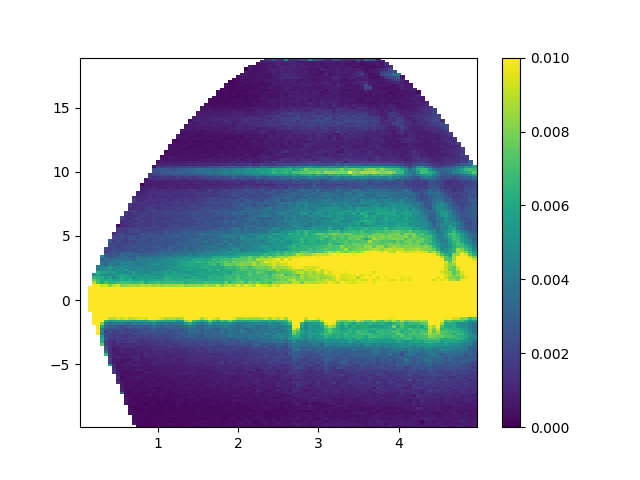

In [42]:
plt.figure()
sqe.plot(hist)
plt.clim(0,1e-2)

In [46]:
sqe2 = hist.copy()[(1.5, 3.5), ()]
sqe2.I[np.logical_not( np.isfinite(sqe2.I) )] = 0
se = sqe2.sum('Q')

<IPython.core.display.Javascript object>


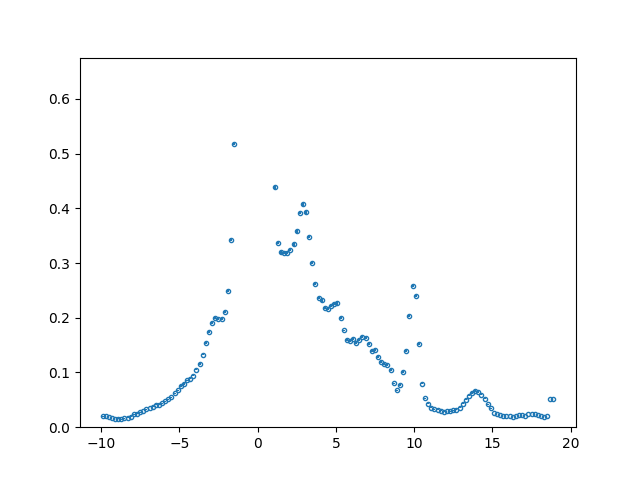

(0, 0.67567218152973152)

In [58]:
plt.figure()
plt.errorbar(se.E, se.I, se.E2**.5, fmt='.', mfc='none')
plt.ylim(0, np.max(se.I)/40)

# Create a function

In [59]:
def getIQE(path, qaxis):
    ws = msa.Load(path)
    reduced = ws
    Edim = reduced.getXDimension()
    emin = Edim.getMinimum()
    emax = Edim.getMaximum()
    de = Edim.getX(1) - Edim.getX(0)
    eaxis = emin, de, emax
    
    qmin, dq, qmax = qaxis; nq = int((qmax-qmin+dq/2.)/dq)
    emin, de, emax = eaxis; ne = int((emax-emin+de/2.)/de)

    md = msa.ConvertToMD(
        InputWorkspace=reduced,
        QDimensions='|Q|',
        dEAnalysisMode='Direct',
        MinValues="%s,%s" % (qmin, emin),
        MaxValues="%s,%s" % (qmax, emax),
    )
    
    binned = msa.BinMD(
        InputWorkspace=md,
        AxisAligned=1,
        AlignedDim0="|Q|,%s,%s,%s" % (qmin, qmax, nq),
        AlignedDim1="DeltaE,%s,%s,%s" % (emin, emax, ne),
    )
    
    import histogram as H, histogram.hdf as hh
    data=binned.getSignalArray().copy()
    err2=binned.getErrorSquaredArray().copy()
    nev=binned.getNumEventsArray()
    data/=nev
    err2/=(nev*nev)
    import numpy as np
    qaxis = H.axis('Q', boundaries=np.arange(qmin, qmax+dq/2., dq), unit='1./angstrom')
    eaxis = H.axis('E', boundaries=np.arange(emin, emax+de/2., de), unit='meV')
    hist = H.histogram('IQE', (qaxis, eaxis), data=data, errors=err2)
    return hist

In [63]:
iqe = getIQE(path, qaxis=(0,0.05,7))

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in divide


<IPython.core.display.Javascript object>


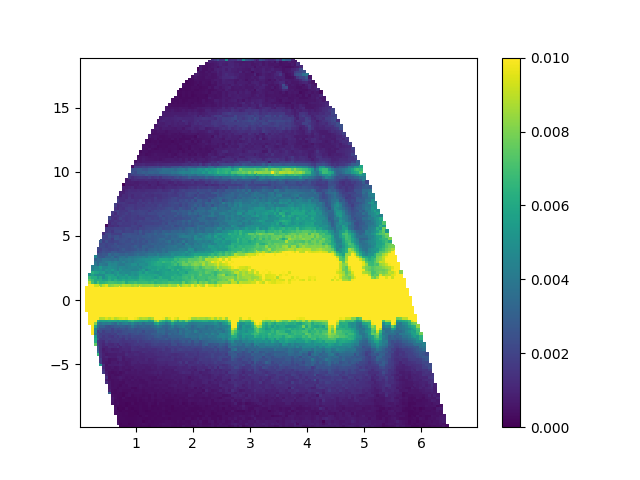

In [64]:
plt.figure()
sqe.plot(iqe)
plt.clim(0,1e-2)

In [110]:
def getIE(path, Ei):
    from mcni.utils import conversion
    maxQ = conversion.e2k(Ei)*2
    iqe = getIQE(path, qaxis=(0,maxQ/100.,maxQ*1.2))
    iqe = iqe[(maxQ/10., maxQ*2/3.), ()]
    iqe.I[np.logical_not( np.isfinite(iqe.I) )] = 0
    return iqe.sum('Q')

In [113]:
ie = getIE(path, Ei=20.)

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in divide


<IPython.core.display.Javascript object>


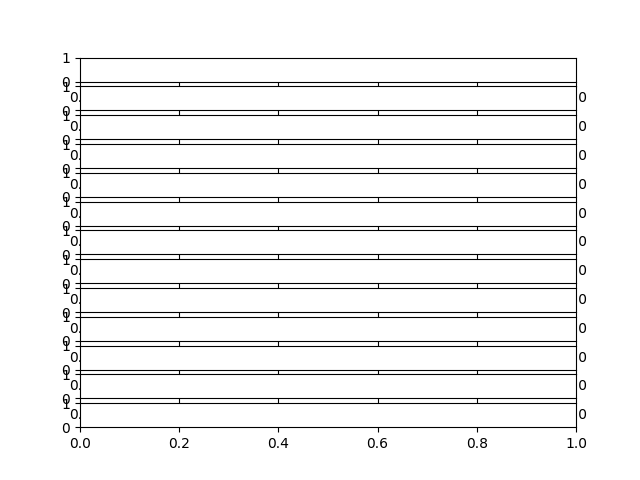

(0, 0.8615673000162325)

In [114]:
plt.figure()
plt.errorbar(ie.E, ie.I, ie.E2**.5, fmt='.', mfc='none')
plt.ylim(0, np.max(ie.I)/40)

# Try more runs

In [71]:
descriptions = '''
113971  C4H2I2S_CCR-16_resolution_20meV_Ch2_240Hz_T0_90Hz
113972  C4H2I2S_CCR-16_resolution_20meV_Ch2_300Hz_T0_90Hz
113973  C4H2I2S_CCR-16_resolution_50meV_Ch2_300Hz_T0_90Hz
113974  C4H2I2S_CCR-16_resolution_50meV_Ch2_420Hz_T0_90Hz
113975  C4H2I2S_CCR-16_resolution_100meV_Ch2_360Hz_T0_90Hz
113976  C4H2I2S_CCR-16_resolution_100meV_Ch2_600Hz_T0_90Hz
113977  C4H2I2S_CCR-16_resolution_200meV_Ch2_600Hz_T0_150Hz
113978  C4H2I2S_CCR-16_resolution_300meV_Ch2_600Hz_T0_150Hz
113979  C4H2I2S_CCR-16_resolution_500meV_Ch1_600Hz_T0_150Hz
113980  C4H2I2S_CCR-16_resolution_500meV_Ch1_480Hz_T0_150Hz
113981  C4H2I2S_CCR-16_resolution_300meV_Ch1_360Hz_T0_150Hz
113982  C4H2I2S_CCR-16_resolution_200meV_Ch1_300Hz_T0_150Hz
113983  C4H2I2S_CCR-16_resolution_100meV_Ch1_240Hz_T0_90Hz
'''

In [80]:
lines = descriptions.strip().splitlines()

In [115]:
%%time
N = len(lines)
table = []
for i, line in enumerate(lines):
    plt.subplot(N, 1, i+1)
    if not line.strip(): continue
    runno, desc = line.split()
    runno = int(runno)
    tokens = desc.split('_')
    for token in tokens:
        if token.endswith('meV'):
            Ei = float(token[:-3])
    print Ei
    path = os.path.join(datadir, 'ARCS_%s_autoreduced.nxspe' % runno)
    ie = getIE(path, Ei=Ei)
    table.append((runno, desc, Ei, path, ie))
    continue

20.0


/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in divide


20.0
50.0
50.0
100.0
100.0
200.0
300.0
500.0
500.0
300.0
200.0
100.0
CPU times: user 37.8 s, sys: 5.64 s, total: 43.4 s
Wall time: 37.4 s


In [116]:
len(lines)

13

<IPython.core.display.Javascript object>


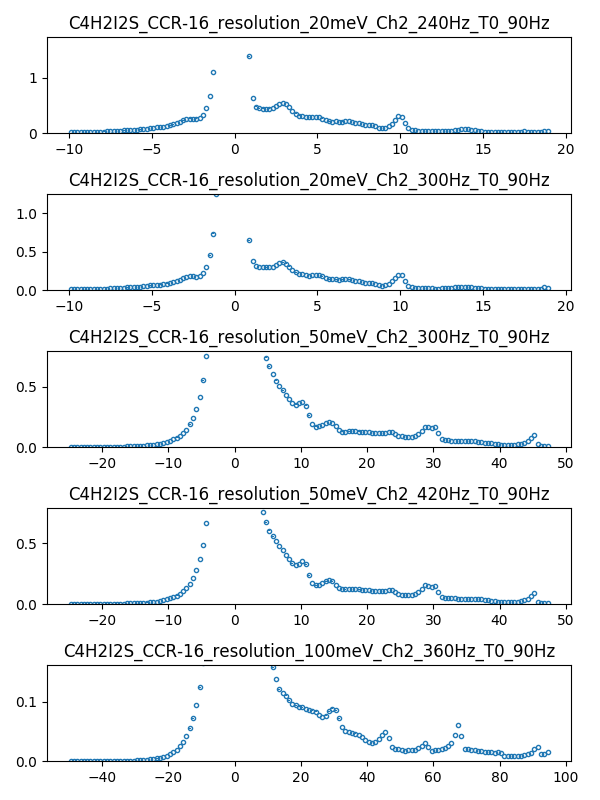

In [117]:
N = 5
plt.figure(figsize=(6, 8))
for i, row in enumerate(table[:5]):
    plt.subplot(N, 1, i+1)
    runno, desc, Ei, path, ie = row
    plt.title(desc)
    plt.errorbar(ie.E, ie.I, ie.E2**.5, fmt='.', mfc='none')
    plt.ylim(0, np.max(ie.I)/20)
    continue
plt.tight_layout()

<IPython.core.display.Javascript object>


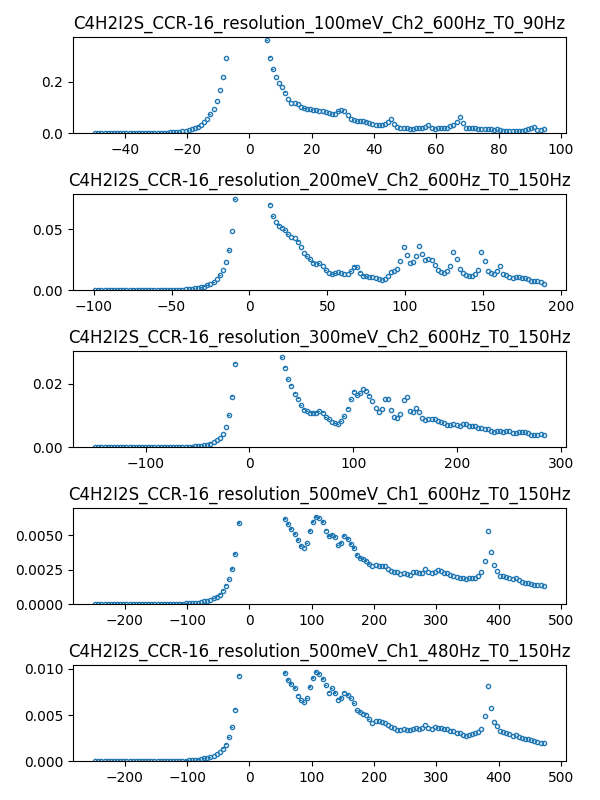

In [118]:
N = 5
plt.figure(figsize=(6, 8))
for i, row in enumerate(table[5:10]):
    plt.subplot(N, 1, i+1)
    runno, desc, Ei, path, ie = row
    plt.title(desc)
    plt.errorbar(ie.E, ie.I, ie.E2**.5, fmt='.', mfc='none')
    plt.ylim(0, np.max(ie.I)/10)
    continue
plt.tight_layout()

<IPython.core.display.Javascript object>


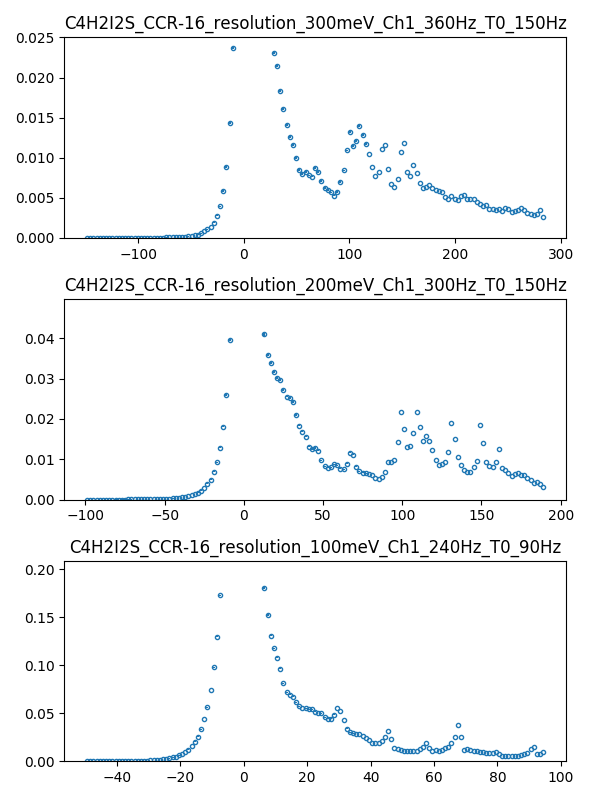

1
2
3


In [119]:
N = 3
plt.figure(figsize=(6, 8))
for i, row in enumerate(table[10:]):
    print i+1
    plt.subplot(N, 1, i+1)
    runno, desc, Ei, path, ie = row
    plt.title(desc)
    plt.errorbar(ie.E, ie.I, ie.E2**.5, fmt='.', mfc='none')
    plt.ylim(0, np.max(ie.I)/10)
    continue
plt.tight_layout()

# Ei=300meV

In [103]:
path = os.path.join(datadir, 'ARCS_113978_autoreduced.nxspe')

In [108]:
iqe = getIQE(path, qaxis=(0,0.1,25))

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in divide


<IPython.core.display.Javascript object>


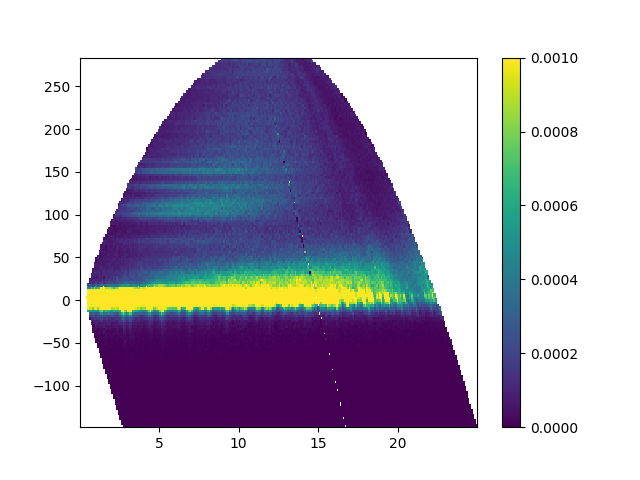

In [120]:
plt.figure()
sqe.plot(iqe)
plt.clim(0, 1e-3)

In [131]:
sqe2 = iqe.copy()[(0.5, 12), ()]
sqe2.I[np.logical_not( np.isfinite(sqe2.I) )] = 0
sqe2.E2[np.logical_not( np.isfinite(sqe2.E2) )] = 0
se = sqe2.sum('Q')

In [138]:
se.size()

145

In [139]:
se.I[70], se.E2[70]**.5

(0.017460673860339344, 0.00023113421501279527)

<IPython.core.display.Javascript object>


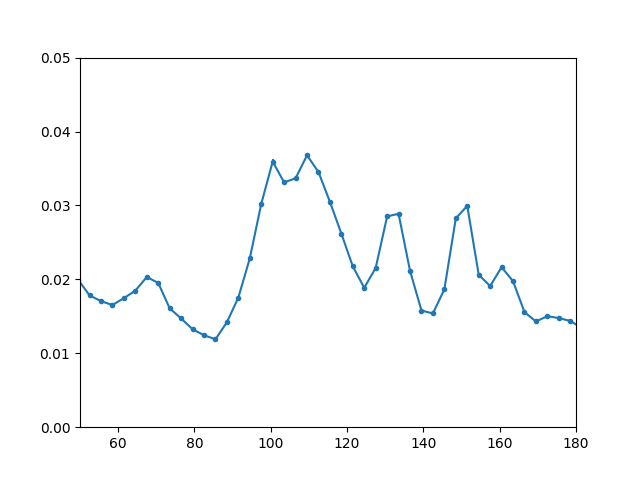

(50, 180)

In [135]:
plt.figure()
plt.errorbar(se.E, se.I, se.E2**.5, fmt='.-')
plt.ylim(0, 0.05)
plt.xlim(50, 180)